# Spam Comment Classification

YouTube has attracted an increasing number of users. However, such success has also attracted malicious users, which aim to self-promote their videos or disseminate viruses and malwares. Since YouTube offers limited tools for comment moderation, the spam volume is shockingly increasing which lead owners of famous channels to disable the comments section in their videos. Automatic comment spam filtering on YouTube is a challenge even for established classification methods, since the messages are very short and often rife with slangs, symbols and abbreviations. In this notebook, we will build a spam comment classification model to automatically filter spams in YouTube comment.


<img src="assets/youtube.png" width="700">


To achieve the aforementioned, the following workflow is performed:
1. **Data Import**: Data is the lifeblood of predictive analytics. We have to know which data to use, where to gather them, and how to make them useful to solve our problem. 
2. **Data Cleaning**: Raw data are generally incomplete, inconsistent, and contain many errors. Thus, we need to prepare the data for further processing. We structure and enrich data into another format with the intent of making it more appropriate and valuable for a variety of downstream purposes, such as analytics. 
3. **Feature Extraction**: We perform feature extraction to transform the original data to a data set with a reduced number of variables, which contains the most discriminatory information.
4. **Data Modelling**: There is no machine learning algorithm that works best in all situations. So, the best approach is to generate a high performance model is by trying multiple algorithms, optimizing them, and comparing them for your specific scenario. Data modelling involves selecting and optiming the machine learning models that generate the best predictive performance based on the data we have. 
5. **Prediction**: Once we have developed the best predictive model, we can deploy it to make predictions. 

### Table of Contents
- [**1.0. Data Import**](#section 1.0.)


- [**2.0. Data Cleaning**](#section 2.0.)
  - [2.1. Lowercase all the words in the data](#section 2.1.)
  - [2.2. Replace URL](#section 2.2.)
  - [2.3. Remove encoding](#section 2.3.)


- [**3.0. Feature Extraction**](#section 3.0.)
  - [3.1. Tokenization](#section 3.1.)
  - [3.2. Stop words removal](#section 3.2.)
  - [3.3. Lemmatization](#section 3.3.)
  - [3.4. Train/test split](#section 3.4.)


- [**4.0. Data Modelling**](#section 4.0.)
  - [4.1. Simple Modelling](#section 4.1.)
  - [4.2. Hyperparameter Optimization for the Best Models](#section 4.2.)


- [**5.0. Prediction**](#section 5.0.)

In [135]:
# Importing data analysis packages
import pandas as pd
import numpy as np

# Importing natural language processing packages
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

# Importing model selection and feature extraction packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer

# Importing machine learning packages
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC 
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Importing data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")

# Miscellaneous
import time
import warnings
warnings.filterwarnings('ignore')

---
<a id='section 1.0.'></a>
## 1.0. Data Import
We import the datasets by calling the following:

In [136]:
# Import dataset
df = pd.read_excel('data/Comment Spam.xls')

# Show the first 5 rows the dataset
df.head()

,No,Comment,Class
0,1,this song is racist,0
1,2,and how many subscribers compared to her over ...,1
2,3,HI! CHECK OUT OUR AWESOME COVERS! AND SAY WHAT...,1
3,4,well done shakira,0
4,5,:D subscribe to me for daily vines,1


We only need data from `Comment` and `Class` column. So, we put them in the `comments` and `labels` variable, respectively. 

In [137]:
comments = df['Comment']
labels = df['Class'].values

Let's see the distribution of labels in the dataset.

In [138]:
pd.Series(labels).value_counts()

1    669
0    631
dtype: int64

As we can see, this dataset is balance. Thus, we will not have the problems of imbalance dataset. 

---
<a id='section 2.0.'></a>
## 2.0. Data Cleaning
To improve the predictive performance of the model, the following data cleaning are performed:
- [**2.1. Lowercase all the words in the data**](#section 2.1.)
- [**2.2. Replace URL**](#section 2.2.)
- [**2.3. Remove encoding**](#section 2.3.)

<a id='section 2.1.'></a>
### 2.1. Lowercase All the Words
Sentences can contain a mixture of uppercase and lower case letters. Multiple sentences make up a text document. To reduce the problem space, the most common approach is to reduce everything to lower case.

In [139]:
# Lowercase all words
comments = comments.apply(lambda x: x.lower())

<a id='section 2.2.'></a>
### 2.2. Replace URL
We will replace all URLs to `http`. 

In [140]:
def replace_url(text, replacement):
    text = str(text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    text = re.sub('[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    
    return text

# Replace url to http
comments = comments.apply(lambda x: replace_url(x, 'http'))

<a id='section 2.3.'></a>
### 2.3. Remove Encoding
Some comments include `\ufeff` encoding. Because this encoding provides no meaning, we will remove it by using `remove_encoding` function.

In [141]:
def remove_encoding(text):
    text = str(text)
    text = text.replace('\ufeff', '')
    return text

# Remove encoding
comments = comments.apply(lambda x: remove_encoding(x))

---
<a id='section 3.0.'></a>
## 3.0. Feature Extraction

There are some feature extraction techniques, such as TF-IDF, Word2Vec, and bag of words. In this problem, we use **bag of words**. Bag of words is one of the simplest techniques of text feature extraction that extracts the most descriptive terms in a document. This method is based on counting number of the words in each document and assign it to a feature space. 

Bag of words is easy to compute and works with an unknown word (e.g., new words in languages). However, it does not capture the position in the text (syntactic) and does not capture meaning in the text (semantics). Common words (e.g., “am”, “is”, etc.) also affect on the results of bag of words.

Before we transform our data into bag of words, we perform the following:
- [**3.1. Tokenization**](#section 3.1.)
- [**3.2. Stop words removal**](#section 3.2.)
- [**3.3. Lemmatization**](#section 3.3.)
- [**3.4. Train/test split**](#section 3.4.)

<a id='section 3.1.'></a>
### 3.1. Tokenization
Tokenization is the process of breaking down a stream of text into words, phrases, symbols, or any other meaningful elements called tokens. The main goal of this step is to extract individual words in a sentence. Along with text classification, in text mining, it is necessary to incorporate a parser in the pipeline which performs the tokenization of the documents. We will be splitting data into a word array using spaces as delimiters.

In [142]:
# tokenize all comments in the data
comments_token = comments.apply(lambda x: x.split())

In [143]:
print('Average word length of comments is {0:.0f}.'.format(np.mean(comments_token.apply(lambda x: len(x)))))
print('Max word length of comments is {0:.0f}.'.format(np.max(comments_token.apply(lambda x: len(x)))))
print('Min word length of comments is {0:.0f}.'.format(np.min(comments_token.apply(lambda x: len(x)))))

Average word length of comments is 16.
Max word length of comments is 213.
Min word length of comments is 1.


<a id='section 3.2.'></a>
### 3.2. Stop Words Removal
Stop words are common words that are found in most texts in a corpus. They are removed from a corpus as they affect on the results of bag of words. Additionally, they provide no meaning or context for analysis.  

In [144]:
stop_words = set(stopwords.words('english')) 

comments_rsw = []
for comment_token in comments_token:
    filtered_comment = [w for w in comment_token if not w in stop_words] 
    comments_rsw.append(filtered_comment)

<a id='section 3.3.'></a>
### 3.3. Lemmatization
Text lemmatization is the process of eliminating redundant prefix or suffix of a word and extract the base word (lemma). Lemmatization is preferred over stemming because lemmatization does morphological analysis of the words.

In [145]:
def lemmatization(dataset):
    lemma = nltk.WordNetLemmatizer()
    comments_lemma = []
    for comment in comments_rsw:
        comment_lemma = [lemma.lemmatize(w) for w in comment]
        comments_lemma.append(comment_lemma)
    return comments_lemma

# Words lemmatization
comments_lemma = lemmatization(comments_rsw)

<a id='section 3.4.'></a>
### 3.4. Train and Test Set Split
We will split our dataset into train set (80%) and test set (20%).

In [146]:
X_train, X_test, y_train, y_test = train_test_split(comments_lemma, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=0, 
                                                    stratify=labels)

<a id='section 3.5.'></a>
### 3.5. Create Bag of Words
There are many uninformative features (words), such as numbers names. We will use only the words that appear in at least 10 comments. In other words, we will use frequent words which are also likely to be in the test set.

In [147]:
# Create bag of words

X_train_untokenized = []

for comment in X_train:
    text = ' '.join(comment)
    X_train_untokenized.append(text)
    
vect = CountVectorizer(min_df=3)
vect.fit(X_train_untokenized)


X_test_untokenized = []

for comment in X_test:
    text = ' '.join(comment)
    X_test_untokenized.append(text)

X_train = vect.transform(X_train_untokenized).toarray()
X_test = vect.transform(X_test_untokenized).toarray()

---
<a id='section 4.0.'></a>
## 4.0. Define Models
There is no machine learning algorithm that works best in all situations. So, the best approach is to generate a high performance model is by trying multiple algorithms, optimizing them, and comparing them for your specific scenario. In this section, we perform the following:
- [**4.1. Simple Modelling**](#section 4.1.): We will handpick several machine learning algorithms and create models based on them and the dataset we have.
- [**4.2. Hyperparameter Optimization for the Best Models**](#section 4.2.): We will pick the best models based on the simple modelling, and then tune their hyperparameters to improve their performance. 

<a id='section 4.1.'></a>
### 4.1. Simple Modelling
We will handpick several machine learning algorithms and create models based on them and the dataset we have. Then, cross-validation is performed to estimate the accuracy of the machine learning models.

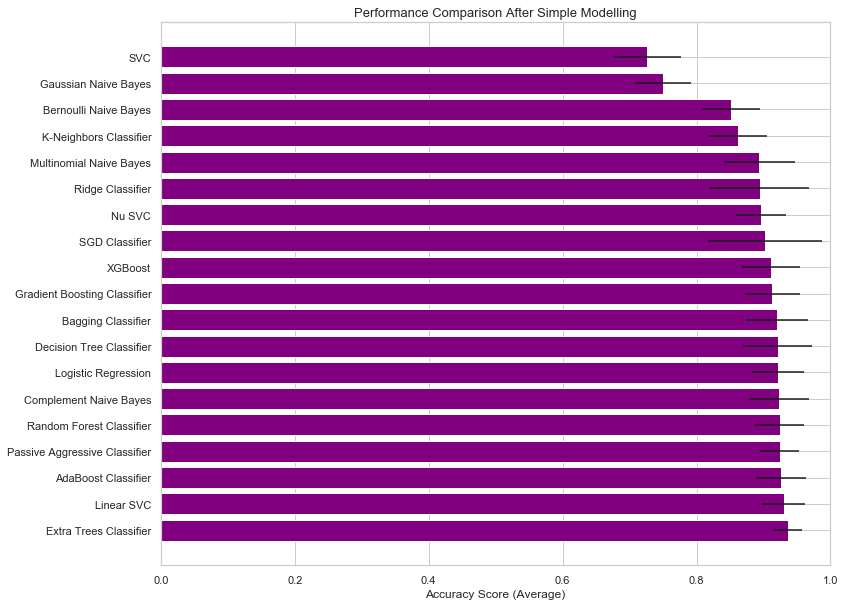

In [148]:
# List of machine learning algorithms that will be used for predictions
estimator = [('Logistic Regression', LogisticRegression), ('Ridge Classifier', RidgeClassifier), 
             ('SGD Classifier', SGDClassifier), ('Passive Aggressive Classifier', PassiveAggressiveClassifier), 
             ('SVC', SVC), ('Linear SVC', LinearSVC), ('Nu SVC', NuSVC), 
             ('K-Neighbors Classifier', KNeighborsClassifier),
             ('Gaussian Naive Bayes', GaussianNB), ('Multinomial Naive Bayes', MultinomialNB), 
             ('Bernoulli Naive Bayes', BernoulliNB), ('Complement Naive Bayes', ComplementNB), 
             ('Decision Tree Classifier', DecisionTreeClassifier), 
             ('Random Forest Classifier', RandomForestClassifier), ('AdaBoost Classifier', AdaBoostClassifier), 
             ('Gradient Boosting Classifier', GradientBoostingClassifier), ('Bagging Classifier', BaggingClassifier), 
             ('Extra Trees Classifier', ExtraTreesClassifier), ('XGBoost', XGBClassifier)]

# Creating a dataframe to compare the performance of the machine learning models
comparison_cols = ['Algorithm', 'Training Time (Avg)', 'Accuracy (Avg)', 'Accuracy (3xSTD)']
comparison_df = pd.DataFrame(columns=comparison_cols)

# Generating training/validation dataset splits for cross validation
cv_split = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

# Performing cross-validation to estimate the performance of the models
for idx, est in enumerate(estimator):
    
    cv_results = cross_validate(est[1](), X_train, y_train, cv=cv_split)
    
    comparison_df.loc[idx, 'Algorithm'] = est[0]
    comparison_df.loc[idx, 'Training Time (Avg)'] = cv_results['fit_time'].mean()
    comparison_df.loc[idx, 'Accuracy (Avg)'] = cv_results['test_score'].mean()
    comparison_df.loc[idx, 'Accuracy (3xSTD)'] = cv_results['test_score'].std() * 3

comparison_df.set_index(keys='Algorithm', inplace=True)
comparison_df.sort_values(by='Accuracy (Avg)', ascending=False, inplace=True)

#Visualizing the performance of the models
fig, ax = plt.subplots(figsize=(12,10))

y_pos = np.arange(len(comparison_df))
ax.barh(y_pos, comparison_df['Accuracy (Avg)'], xerr=comparison_df['Accuracy (3xSTD)'], color='purple')
ax.set_yticks(y_pos)
ax.set_yticklabels(comparison_df.index)
ax.set_xlabel('Accuracy Score (Average)')
ax.set_title('Performance Comparison After Simple Modelling', size=13)
ax.set_xlim(0, 1)

plt.show()

Based on the chart above, we can achieve ~93% accuracy by performing simple modelling. In the next section, we will try to improve the models by tuning their hyperparameters.  

<a id='section 4.2.'></a>
### 4.2. Hyperparameter Optimization for the Best Models
Hyperparameters are parameters whose value are set before the learning process begins. In other words, we cannot optimize hyperparameters through learning process. Hyperparameter optimization is the process of selecting the values for a model’s hyperparameters that maximize the accuracy of the model. In this section, we pick 8 top models to be optimized. We use [grid-search cross-validation](https://chrisalbon.com/machine_learning/model_evaluation/cross_validation_parameter_tuning_grid_search/) method to optimize the hyperparameters. 

In [149]:
# A list of machine learning algorithms that will be optimized
estimator = [('Extra Trees Classifier', ExtraTreesClassifier), 
             ('Linear SVC', LinearSVC), ('Bagging Classifier', BaggingClassifier),
             ('Gradient Boosting Classifier', GradientBoostingClassifier),
             ('AdaBoost Classifier', AdaBoostClassifier),
             ('Random Forest Classifier', RandomForestClassifier),
             ('Logistic Regression', LogisticRegression),  
             ('Passive Aggressive Classifier', PassiveAggressiveClassifier)]

index = [est[0] for est in estimator]

# A dictionary containing hyperparameters that are to be optimized for each machine learning algorithm
grid_params = {'SVC': {'C': np.arange(1,21,1), 'gamma': [0.005, 0.01, 0.015, 0.02], 'random_state': [0]},
               'Ridge Classifier': {'alpha': [0.001, 0.0025, 0.005], 'random_state': [0]},
               'Nu SVC': {'nu': [0.5], 'gamma': [0.001, 0.01, 0.1, 1], 'random_state': [0]},
               'Gradient Boosting Classifier': {'learning_rate': [0.001, 0.005, 0.01, 0.015], 'random_state': [0],
                                                'max_depth': [1,2,3,4,5], 'n_estimators': [300, 350, 400, 450, 500]},
               'Linear SVC': {'C': [1, 5, 10], 'random_state': [0]},
               'Logistic Regression': {'C': np.arange(2,7.5,0.25), 
                                       'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                                       'random_state': [0]},
               'AdaBoost Classifier': {'learning_rate': np.arange(0.05, 0.21, 0.01), 'n_estimators': [50, 75, 100, 125, 150], 
                                       'random_state': [0]},
               'Random Forest Classifier': {'n_estimators': [200, 250, 300, 350], 'max_depth': [1,2,3,4,5,6], 
                                            'criterion': ['gini', 'entropy'], 'random_state': [0]},
               'Bagging Classifier': {'n_estimators': np.arange(200, 300, 10), 'random_state': [0]},
               'XGBoost': {'learning_rate': [0.001, 0.005, 0.01, 0.015], 'random_state': [0],
                           'max_depth': [1,2,3,4,5], 'n_estimators': [300, 350, 400, 450, 500]},
               'Extra Trees Classifier': {'n_estimators': [10, 20, 50, 100], 'criterion': ['gini', 'entropy'],
                                          'random_state': [0]},
               'Passive Aggressive Classifier': {'C': np.arange(1,21,1)}
              }

# Creating a dataframe to compare the performance of the machine learning models after hyperparameter optimization 
best_params_df = pd.DataFrame(columns=['Optimized Hyperparameters', 'Accuracy'], index=index)

# Performing grid-search cross-validation to optimize hyperparameters and estimate the performance of the models
for idx, est in enumerate(estimator):
    
    best_clf = GridSearchCV(est[1](), param_grid=grid_params[est[0]], cv=cv_split, scoring='accuracy', n_jobs=12)
    best_clf.fit(X_train, y_train)
    
    best_params_df.loc[est[0], 'Optimized Hyperparameters'] = [best_clf.best_params_]
    best_params_df.loc[est[0], 'Accuracy'] = best_clf.best_score_
    

The results of grid-search cross-validation is shown below:

In [150]:
# Showing the results of grid-search cross-validation
best_params_df.sort_values('Accuracy')

,Optimized Hyperparameters,Accuracy
Random Forest Classifier,"[{'criterion': 'entropy', 'max_depth': 1, 'n_e...",0.881731
Gradient Boosting Classifier,"[{'learning_rate': 0.015, 'max_depth': 5, 'n_e...",0.923397
Bagging Classifier,"[{'n_estimators': 200, 'random_state': 0}]",0.925641
Passive Aggressive Classifier,[{'C': 20}],0.927885
AdaBoost Classifier,"[{'learning_rate': 0.18000000000000005, 'n_est...",0.928526
Linear SVC,"[{'C': 1, 'random_state': 0}]",0.930128
Logistic Regression,"[{'C': 6.0, 'random_state': 0, 'solver': 'libl...",0.932051
Extra Trees Classifier,"[{'criterion': 'gini', 'n_estimators': 100, 'r...",0.943269


In [153]:
best_params_df.loc['Extra Trees Classifier', 'Optimized Hyperparameters']

[{'criterion': 'gini', 'n_estimators': 100, 'random_state': 0}]

The best performance is achieved by extra trees classifier with 94.32% accuracy. This is a slight improvement from 93.58% accuracy achieved by simple modelling. 

---
<a id='section 5.0.'></a>
## 5.0. Prediction
We use extra trees classifier with hyperparameter optimization to make predictions using the test set.

In [154]:
from sklearn.metrics import accuracy_score

clf = ExtraTreesClassifier(criterion = 'gini',
                           n_estimators = 100,
                           random_state = 0)

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print('The accuracy of the model based on the test set: {}'.format(accuracy_score(y_test, predictions)))

The accuracy of the model based on the test set: 0.9423076923076923


The result is not too different to the training result. It shows that our model does not overfit the training set.
We strictly use our evaluation based on accuracy metric. Accuracy is selected, as it can provide insight regarding the overall performance of the classifier in predicting unseen instances. To provide more insights regarding the model performance, we evaluate precision, recall, and F1 score of the model.
- **Precision** measures the ability of the classifier to make a correct positive prediction. Precision addresses the question: "Among all positive predictions, what is the probability of them being correct?” However, a classifier with a high precision score does not necessarily imply a good prediction model, as it may indicate that the classifier misses numerous positive instances in the dataset.
- **Recall** is used to complement precision by measuring the ability of the clas- sifier to discover instances with a positive class. Recall addresses the question: "Of all items that belong to a positive class, what fractions does the classifier correctly detect as positive?”
- **F1 score** is the weighted average of precision and recall. Therefore, this score takes both false positives and false negatives into account.

Let's see the performance of the model in terms of precision, recall, and F1 score.

In [157]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('The precision of the model based on the test set: {}'.format(precision_score(y_test, predictions)))
print('The recall of the model based on the test set: {}'.format(recall_score(y_test, predictions)))
print('The F1 score of the model based on the test set: {}'.format(f1_score(y_test, predictions)))

The precision of the model based on the test set: 0.9541984732824428
The recall of the model based on the test set: 0.9328358208955224
The F1 score of the model based on the test set: 0.9433962264150944
